# Chapter 12: Advanced Designs - Multi-Variant and Factorial Experiments

This notebook contains all code examples from Chapter 12, demonstrating:
1. Multi-variant (A/B/n) testing with ANOVA and Tukey's HSD
2. Sample size calculations for A/B/n tests
3. Factorial experiments (2x2 design) with two-way ANOVA
4. Interaction effect analysis and visualization

## Setup: Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import FTestAnovaPower
import matplotlib.pyplot as plt
import seaborn as sns

## Section 1.5.2: Sample Size Calculation for A/B/n Tests

Example from Chapter 12 showing how to calculate required sample size for a 4-group A/B/C/D test.

In [3]:
from statsmodels.stats.power import FTestAnovaPower

# --- Inputs ---
effect_size = 0.2  # Cohen's f. A medium effect size.
alpha = 0.05       # Significance level
power = 0.80       # Desired power
k_groups = 4       # For an A/B/C/D test

# --- Calculation ---
power_analyzer = FTestAnovaPower()
sample_size_per_group = power_analyzer.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    k_groups=k_groups,
    nobs=None  # We want to solve for this
)

print(f"Required sample size per group: {sample_size_per_group:.2f}")
print(f"Total required sample size: {sample_size_per_group * k_groups:.2f}")

Required sample size per group: 276.50
Total required sample size: 1106.01


## Section 1.6: A/B/C/D Experiment with ANOVA and Tukey's HSD

Complete implementation of an A/B/C/D test demonstrating:
- One-Way ANOVA omnibus test
- Tukey's HSD post-hoc test

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def run_anova_and_tukey_test():
    """
    Simulates an A/B/C/D experiment and analyzes it using ANOVA and Tukey's HSD.
    """
    # --- Experiment Setup ---
    np.random.seed(101)
    
    # Control and three variants
    # Let's assume C is a winner, B is a loser, and D is neutral.
    control_data = np.random.normal(10, 2, 1000)  # Mean=10
    variant_b_data = np.random.normal(9.5, 2, 1000) # Mean=9.5
    variant_c_data = np.random.normal(11, 2, 1000)  # Mean=11
    variant_d_data = np.random.normal(10.1, 2, 1000) # Mean=10.1

    # Combine into a single DataFrame, which is the required format for statsmodels
    df = pd.DataFrame({
        'value': np.concatenate([control_data, variant_b_data, variant_c_data, variant_d_data]),
        'group': ['A'] * 1000 + ['B'] * 1000 + ['C'] * 1000 + ['D'] * 1000
    })

    print("--- Step 1: ANOVA Omnibus Test ---")
    
    # 1. Fit the ANOVA model
    # The formula 'value ~ group' tells the model to explain 'value' based on 'group'
    model = ols('value ~ group', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print(anova_table)
    
    # 2. Check the p-value from the ANOVA test
    anova_p_value = anova_table['PR(>F)'][0]
    
    if anova_p_value >= 0.05:
        print(f"\nANOVA p-value ({anova_p_value:.4f}) is not significant. Stop analysis.")
        return
    else:
        print(f"\nANOVA p-value ({anova_p_value:.4f}) is significant. Proceed to post-hoc test.")

    print("\n--- Step 2: Tukey's HSD Post-Hoc Test ---")
    
    # 3. Perform Tukey's Honestly Significant Difference (HSD) test
    tukey_results = pairwise_tukeyhsd(endog=df['value'], groups=df['group'], alpha=0.05)
    
    print(tukey_results)
    
    print("\n--- Conclusion ---")
    print("The Tukey HSD results show which pairs have a statistically significant difference (reject=True).")
    print("In this case, we correctly identify that C is significantly better than A, B, and D, and B is significantly worse than A.")

# Run the analysis
run_anova_and_tukey_test()

--- Step 1: ANOVA Omnibus Test ---
                sum_sq      df          F        PR(>F)
group      1196.807410     3.0  94.504032  4.334375e-59
Residual  16868.565752  3996.0        NaN           NaN

ANOVA p-value (0.0000) is significant. Proceed to post-hoc test.

--- Step 2: Tukey's HSD Post-Hoc Test ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_149136\3524682422.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anova_p_value = anova_table['PR(>F)'][0]


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     A      B  -0.4563   0.0 -0.6925 -0.2202   True
     A      C    1.043   0.0  0.8068  1.2791   True
     A      D   0.0517 0.943 -0.1844  0.2879  False
     B      C   1.4993   0.0  1.2631  1.7354   True
     B      D   0.5081   0.0  0.2719  0.7442   True
     C      D  -0.9912   0.0 -1.2274 -0.7551   True
---------------------------------------------------

--- Conclusion ---
The Tukey HSD results show which pairs have a statistically significant difference (reject=True).
In this case, we correctly identify that C is significantly better than A, B, and D, and B is significantly worse than A.


## Section 2.5: Factorial Experiment (2x2 Design) with Two-Way ANOVA

Implementation of a 2x2 factorial experiment testing:
- Factor A: Headline (Old vs. New)
- Factor B: Button Color (Old vs. New)
- Measures main effects and interaction effects

In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

def run_factorial_experiment_analysis():
    """
    Simulates a 2x2 factorial experiment and analyzes it with a Two-Way ANOVA.
    """
    # --- Experiment Setup ---
    np.random.seed(202)
    n_users_per_group = 5000

    # Let's assume the new headline has a positive effect (+0.5)
    # and the new button color has a positive effect (+0.3).
    # Crucially, let's add a positive interaction effect (+0.4)
    # that only occurs when both are present.
    
    # Group 1: Old Headline, Old Button (Control)
    g1_data = np.random.normal(5.0, 2, n_users_per_group)
    
    # Group 2: New Headline, Old Button
    g2_data = np.random.normal(5.0 + 0.5, 2, n_users_per_group)
    
    # Group 3: Old Headline, New Button
    g3_data = np.random.normal(5.0 + 0.3, 2, n_users_per_group)
    
    # Group 4: New Headline, New Button (Main effects + Interaction effect)
    g4_data = np.random.normal(5.0 + 0.5 + 0.3 + 0.4, 2, n_users_per_group)

    # Combine into a DataFrame
    df = pd.DataFrame({
        'value': np.concatenate([g1_data, g2_data, g3_data, g4_data]),
        'headline': ['Old', 'New'] * (2 * n_users_per_group),
        'button': ['Old'] * (2 * n_users_per_group) + ['New'] * (2 * n_users_per_group)
    })

    print("--- Two-Way ANOVA Analysis ---")
    
    # Fit the ANOVA model. The formula 'value ~ headline * button' is shorthand
    # for 'value ~ headline + button + headline:button', which tests both
    # main effects and the interaction effect.
    model = ols('value ~ C(headline) * C(button)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print(anova_table)

    print("\n--- Interpretation ---")
    p_headline = anova_table.loc['C(headline)', 'PR(>F)']
    p_button = anova_table.loc['C(button)', 'PR(>F)']
    p_interaction = anova_table.loc['C(headline):C(button)', 'PR(>F)']

    print(f"P-value for Main Effect of Headline: {p_headline:.4f}")
    if p_headline < 0.05:
        print("  -> Conclusion: The headline change had a significant main effect.")
    
    print(f"P-value for Main Effect of Button: {p_button:.4f}")
    if p_button < 0.05:
        print("  -> Conclusion: The button color change had a significant main effect.")

    print(f"P-value for Interaction Effect: {p_interaction:.4f}")
    if p_interaction < 0.05:
        print("  -> Conclusion: There is a significant interaction between headline and button.")
        print("     This means the effect of the headline depends on the button color (and vice-versa).")
        print("     Launching both features together produces a synergistic effect different from their individual impacts.")

# Run the analysis
run_factorial_experiment_analysis()

--- Two-Way ANOVA Analysis ---
                             sum_sq       df           F        PR(>F)
C(headline)                2.092722      1.0    0.508883  4.756311e-01
C(button)               1332.709093      1.0  324.072229  6.942993e-72
C(headline):C(button)     17.384396      1.0    4.227329  3.979094e-02
Residual               82231.208562  19996.0         NaN           NaN

--- Interpretation ---
P-value for Main Effect of Headline: 0.4756
P-value for Main Effect of Button: 0.0000
  -> Conclusion: The button color change had a significant main effect.
P-value for Interaction Effect: 0.0398
  -> Conclusion: There is a significant interaction between headline and button.
     This means the effect of the headline depends on the button color (and vice-versa).
     Launching both features together produces a synergistic effect different from their individual impacts.


## Section 2.6: Visualizing Interaction Effects

Generate an interaction plot to visualize how the two factors interact.

Plot saved to: ..\Images\ch12_interaction_plot.png


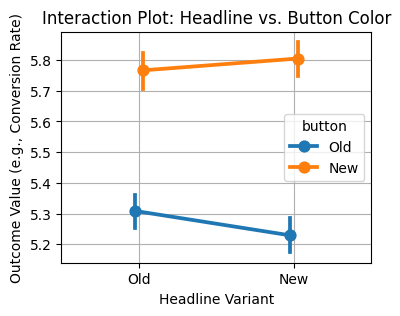

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_interaction(df, save_path=None):
    """
    Generates an interaction plot to visualize the results of the factorial experiment.
    """
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.pointplot(data=df, x='headline', y='value', hue='button', ax=ax, dodge=True)
    
    ax.set_title('Interaction Plot: Headline vs. Button Color')
    ax.set_ylabel('Outcome Value (e.g., Conversion Rate)')
    ax.set_xlabel('Headline Variant')
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()

# Recreate data from factorial experiment
np.random.seed(202)
n_users_per_group = 5000
g1_data = np.random.normal(5.0, 2, n_users_per_group)
g2_data = np.random.normal(5.0 + 0.5, 2, n_users_per_group)
g3_data = np.random.normal(5.0 + 0.3, 2, n_users_per_group)
g4_data = np.random.normal(5.0 + 0.5 + 0.3 + 0.4, 2, n_users_per_group)

df = pd.DataFrame({
    'value': np.concatenate([g1_data, g2_data, g3_data, g4_data]),
    'headline': ['Old', 'New'] * (2 * n_users_per_group),
    'button': ['Old'] * (2 * n_users_per_group) + ['New'] * (2 * n_users_per_group)
})

# Create Images directory if it doesn't exist
images_dir = os.path.join('..', 'Images')
os.makedirs(images_dir, exist_ok=True)

# Generate and save the plot
save_path = os.path.join(images_dir, 'ch12_interaction_plot.png')
plot_interaction(df, save_path=save_path)